In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

In [4]:
# Plotting utility
from IPython.display import clear_output
class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1

        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))

        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        # axes[0].set_yscale('log')
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()

        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        # axes[1].set_ylim(0.85,1.)
        axes[1].legend()

        plt.tight_layout()
        plt.show();

In [6]:
!pip install photutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00


In [7]:
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

stop_dir = '/content/gdrive/MyDrive/Colab Notebooks/michel_images/michel_images/stop'
thru_dir = '/content/gdrive/MyDrive/Colab Notebooks/michel_images/michel_images/thru'

def load_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            filepath = os.path.join(directory, filename)
            image = Image.open(filepath)
            images.append(np.array(image))
            labels.append(label)
    return images, labels

# Load and label the images from each directory
stop_images, stop_labels = load_images(stop_dir, label=0)  # Label 'stop' muons as 0
thru_images, thru_labels = load_images(thru_dir, label=1)  # Label 'thru' muons as 1

# Combine and shuffle the datasets
all_images = np.array(stop_images + thru_images)
all_labels = np.array(stop_labels + thru_labels)
all_images, all_labels = shuffle(all_images, all_labels, random_state=0)


In [8]:
# Normalize the images by dividing each pixel value by 255
normalized_images = all_images.astype(np.float32) / 255.0

# Display the normalized array
print("Normalized image data:")
print(normalized_images)

# Optionally, you can show the shape of the array to confirm its structure
print("Shape of the normalized image array:", normalized_images.shape)

Normalized image data:
[[[0.03529412 0.03529412 0.03529412 ... 0.03921569 0.03921569 0.03529412]
  [0.02352941 0.02352941 0.02352941 ... 0.02745098 0.02745098 0.02745098]
  [0.03137255 0.03137255 0.03137255 ... 0.02352941 0.02352941 0.02352941]
  ...
  [0.02745098 0.02745098 0.02745098 ... 0.02745098 0.02745098 0.02745098]
  [0.02745098 0.02745098 0.02745098 ... 0.03137255 0.02745098 0.02745098]
  [0.02745098 0.02745098 0.02745098 ... 0.03137255 0.03137255 0.02745098]]

 [[0.02745098 0.02745098 0.02745098 ... 0.02352941 0.02745098 0.03137255]
  [0.02745098 0.02745098 0.02745098 ... 0.01176471 0.01568628 0.01568628]
  [0.02745098 0.02745098 0.02745098 ... 0.02352941 0.02352941 0.02745098]
  ...
  [0.02352941 0.02352941 0.02745098 ... 0.03137255 0.02745098 0.02352941]
  [0.03137255 0.03137255 0.02745098 ... 0.03137255 0.03137255 0.03137255]
  [0.03529412 0.03137255 0.03137255 ... 0.03529412 0.03529412 0.03529412]]

 [[0.02745098 0.02745098 0.02745098 ... 0.02745098 0.02745098 0.03137255]

In [9]:
# build the CNN and train
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(normalized_images, all_labels, test_size=0.2, random_state=42)

# Assuming images are grayscale and reshaping them to include the channel dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (1097, 480, 300, 1)
X_test shape: (275, 480, 300, 1)


In [91]:
# Define the CNN architecture with the updated input shape
model = models.Sequential([
    layers.Conv2D(4, (2, 2), activation='relu', input_shape=(480, 300, 1)),  # Updated input shape
    #layers.SpatialDropout2D(0.25),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='relu'),
    #layers.Dropout(0.25),
    layers.Dense(2, activation='softmax')  # Using softmax for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=200, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)


Epoch 1/10
6/6 [==============================] - 4s 345ms/step - loss: 0.6274 - accuracy: 0.6563 - val_loss: 0.3875 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 1s 197ms/step - loss: 0.3344 - accuracy: 1.0000 - val_loss: 0.2103 - val_accuracy: 0.9891
Epoch 3/10
6/6 [==============================] - 1s 167ms/step - loss: 0.1663 - accuracy: 0.9973 - val_loss: 0.1005 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 1s 127ms/step - loss: 0.0809 - accuracy: 0.9982 - val_loss: 0.0536 - val_accuracy: 0.9927
Epoch 5/10
6/6 [==============================] - 1s 137ms/step - loss: 0.0444 - accuracy: 0.9982 - val_loss: 0.0320 - val_accuracy: 0.9964
Epoch 6/10
6/6 [==============================] - 1s 163ms/step - loss: 0.0281 - accuracy: 0.9982 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 130ms/step - loss: 0.0191 - accuracy: 0.9991 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 8/10
6/6 [====

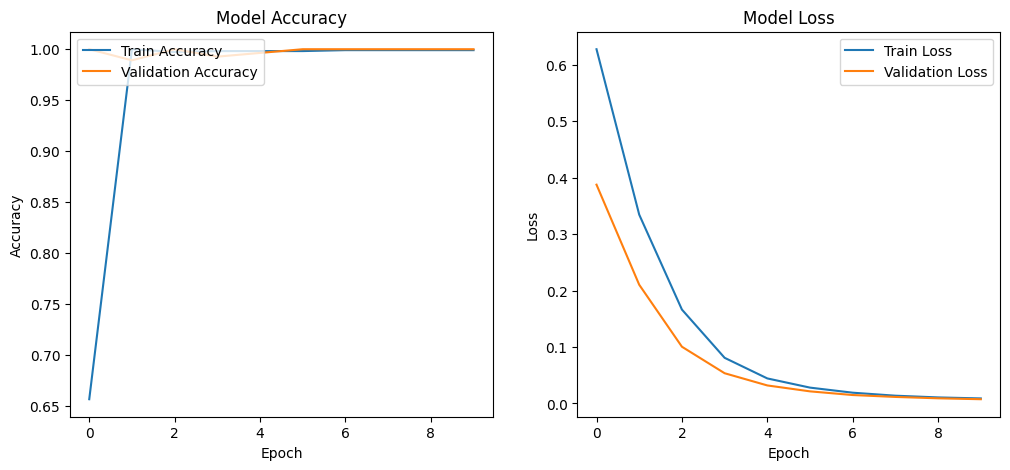

In [93]:
#look at performance

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [94]:
# Printing the test accuracy and loss
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.007556029129773378
Test Accuracy: 1.0


9/9 [==============================] - 0s 28ms/step


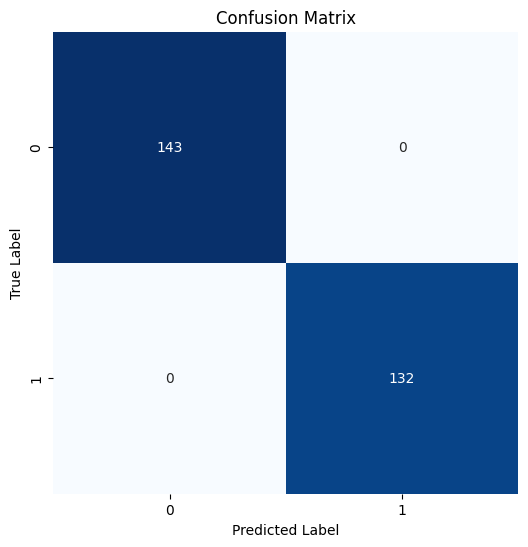

In [97]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#print(y_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
